# GRO620 - Activité procédurale 2

Dans cette activité procédurale, nous allons poser les bases dufiltrage numérique d'images. Vous reconnaîtrez des éléments du filtrage numérique que vous avez vu en S4.

Pour chaque question impliqant de la programmation, commencez par discuter de la procédure à suivre pour résoudre le problème. Nous validerons l'approche en classe avant de se lancer dans l'implémentation.

In [1]:
# Préambule

import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Caractéristiques de la lumière

### Q1.1

Dans cette image synthétique : 

![](images_doc/proc1-q4-specular.jpg)

(source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Specular_highlight.jpg))

**a)** Quelle(s) partie(s) correspondent à l'illumination diffuse et les reflets spéculaires ?

- Illumination diffuse : Les deux sphères et le plancher.
- Spéculaire : Reflets blancs qui sont reflétés directement.

**b)** Quelle information est nécessaire pour déterminer les caractéristiques et emplacements exacts des sources de lumières dans cette image ? Répondez en utilisant des éléments de la *Bidirectional Reflectance Distribution Function* (BRDF).

- Angle incident
- Angle réfléchi
- Surface isotropique?
- Taille des réflets spéculaires
- Caractéristiques de la lumière (longueur d'onde, taille et distance de la source, etc)

## Encodage de l'image

Pour les questions suivantes, vous aurez probablement besoin de lire la documentation de cv2.imread et matplotlib.pyplot.imshow :

[imread](https://pythonexamples.org/python-opencv-read-image-cv2-imread/)

[imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

Le code suivant charge une image et l'affiche en ligne :

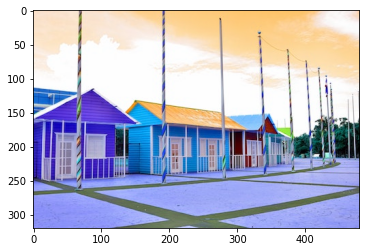

In [2]:
img_color = cv2.imread("images_doc/proc1-q3-color.jpeg")
plt.imshow(img_color)

(source de l'image: [PixaBay, Pexels](https://www.pexels.com/photo/apartment-architecture-block-blue-534124/))

### Q2.1

**a)** Ouvrez directement l'image dans un autre logiciel (le fichier se trouve dans images_doc/proc1-q3-color.jpeg) et comparez le résultat. Que remarquez vous ?

- L'image est en couleurs BGR et non RGB.

**b)** Affichez seulement le premier canal de couleurs de l'image. Pensez à analyser la composition de la matrice image que OpenCV vous retourne. Expliquez ensuite ce que vous voyez.

(320, 480, 3)


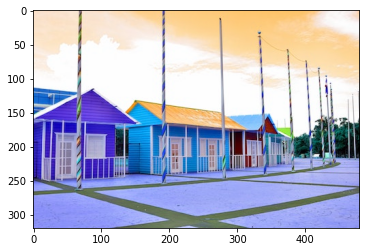

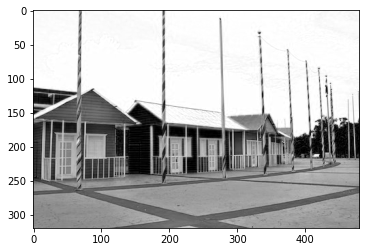

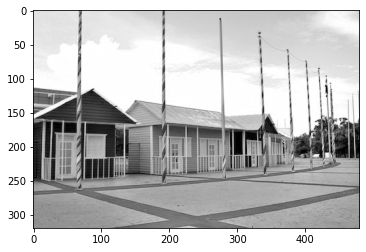

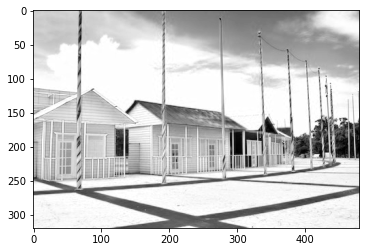

In [3]:
plt.imshow(img_color)
print(img_color.shape)
plt.figure()                      
plt.imshow(img_color[:,:,0], cmap="gray")

plt.figure()
plt.imshow(img_color[:,:,1], cmap="gray")

plt.figure()
plt.imshow(img_color[:,:,2], cmap="gray")

**c)** Transformez maintenant l'image pour que les couleurs correspondent à ce que vous voyez en dehors de Jupyter.

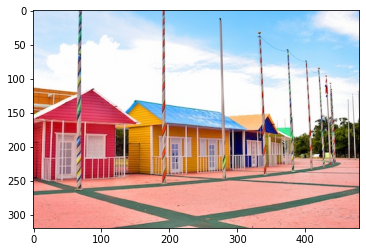

In [4]:
img_rgb = img_color.copy() 
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)                                

### Q2.2

Soit cette couleur dans l'espace Y'CbCr (on suppose chaque valeur comme étant encodée sur 8 bits) :

$c = [100, 150, 150]$

Trouvez sa valeur équivalente dans l'espace RGB.

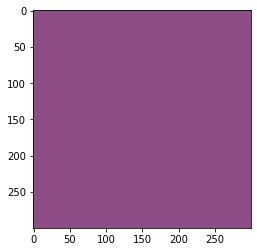

In [5]:
c = np.array([100, 150, 150])
c_img = np.zeros([300, 300, 3], np.uint8)

for i in range(300):
    for j in range(300):
        c_img[i, j] = c

c_bgr = cv2.cvtColor(c_img, cv2.COLOR_YCrCb2BGR)
plt.imshow(c_bgr)

## Filtrage point à point

### Q3.1

Soit cette image (chargée par OpenCV et affichée par matplotlib): 

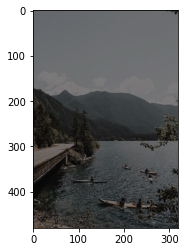

In [6]:
img_q31_org = cv2.imread("images_doc/proc2-q1-dock.jpeg")
img_q31_rgb = cv2.cvtColor(img_q31_org, cv2.COLOR_BGR2RGB) 
plt.imshow(img_q31_rgb)

(Source de l'image originale : [Vlada Karpovich, Pexels](https://www.pexels.com/photo/snow-wood-landscape-mountains-4450090/))

Cette fonction affiche l'histogramme des trois composantes de l'image :

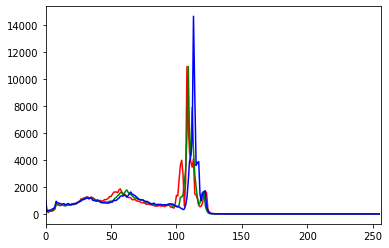

In [7]:
channels = ('r','g','b')
for i, col in enumerate(channels):
    hist = cv2.calcHist([img_q31_rgb], [i], None, [256], [0,256])
    plt.plot(hist,color = col)
    plt.xlim([0,256])

Ajustez la plage dynamique en luminosité de l'image pour qu'elle couvre l'ensemble des valeurs possibles.

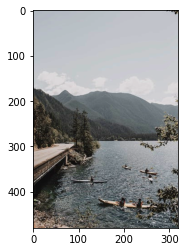

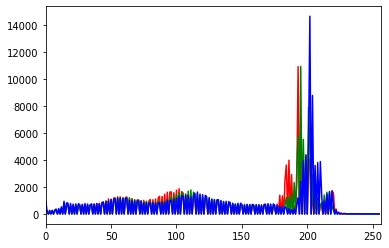

In [8]:
img_q31_f = np.float32(img_q31_rgb) / 255.0

min_val = np.min(img_q31_f)
max_val = np.max(img_q31_f)

img_q31_out = (img_q31_f - min_val) / (max_val - min_val)
plt.imshow(img_q31_out)

# New histogram

plt.figure()
channels = ('r','g','b')
for i, col in enumerate(channels):
    hist = cv2.calcHist([img_q31_out*255], [i], None, [256], [0,256])
    plt.plot(hist,color = col)
    plt.xlim([0,256])

## Q3.2

Soit maintenant cette image :

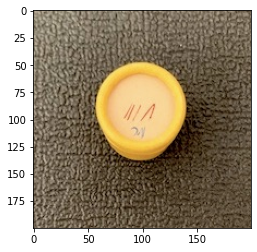

In [9]:
img_q32_org = cv2.imread("images_doc/proc2-q1-object.jpeg")
img_q32_rgb = cv2.cvtColor(img_q32_org, cv2.COLOR_BGR2RGB) 
plt.imshow(img_q32_rgb)


Tentez de mettre en place un algorithme basé sur la luminosité permettant d'éliminer l'arrière-plan de cette image pour qu'il ne reste que l'objet en jaune sur un fond le plus noir possible.

- On voit que la plage de 0-90 correspond au background.

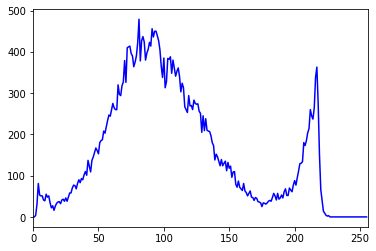

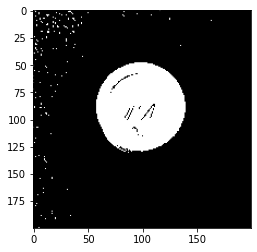

In [10]:
img_gray = cv2.cvtColor(img_q32_rgb, cv2.COLOR_RGB2GRAY)

plt.figure()
hist = cv2.calcHist([img_gray], [0], None, [256], [0,256])
plt.plot(hist,color = col)
plt.xlim([0,256])

plt.figure()
thresh, img_bw = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY)
plt.imshow(img_bw, cmap='gray')


## Filtrage linéaire

### Q4.1 

Soit l'image suivante ainsi que sa transformée de Fourier :

(<matplotlib.axes._subplots.AxesSubplot at 0x7fefac23a1f0>,
 <matplotlib.image.AxesImage at 0x7fefa5deefd0>)

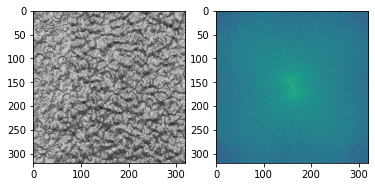

In [11]:
img_q4_org  = cv2.imread("images_doc/proc2-q2-texture.jpeg")
img_q4_mono = np.float32(cv2.cvtColor(img_q4_org, cv2.COLOR_BGR2GRAY)) / 255.0

def get_fft_mag(img):
    img_fft = np.fft.fft2(img)
    img_fft = np.fft.fftshift(img_fft)
    img_fft = 20*np.log(np.abs(img_fft))
    return img_fft
    
img_q4_fft = get_fft_mag(img_q4_mono)

plt.subplot(121),plt.imshow(img_q4_mono, cmap="gray")
plt.subplot(122),plt.imshow(img_q4_fft)

(Source de l'image originale : [Hoang Le, Pexels](https://www.pexels.com/photo/black-and-white-black-and-white-pattern-rough-978462/)).

**a)** Filtrez cette image à l'aide d'une convolution de façon à ce que la valeur de chaque pixel soit la valeur moyenne de ses voisins dans un carré de 15x15.

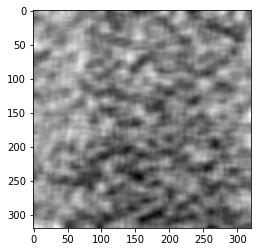

In [12]:
filter_kernel = np.ones((15,15))/(15*15)
img_filtered = cv2.filter2D(img_q4_mono, -1, filter_kernel)
plt.figure()
plt.imshow(img_filtered, cmap='gray')


**b)** Comparez le résultat avec celui de la fonction cv2.GaussianBlur() avec un noyau de convolution de la même taille.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fefa5dd8790>,
 <matplotlib.image.AxesImage at 0x7fefac22d5e0>)

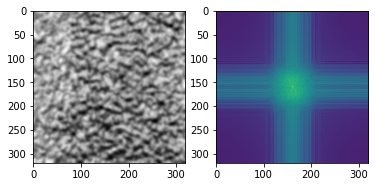

In [13]:
img_q4_blur = cv2.GaussianBlur(img_q4_mono,(15,15), 0)

img_q4_blur_fft = get_fft_mag(img_q4_blur)

plt.subplot(121),plt.imshow(img_q4_blur, cmap='gray')
plt.subplot(122),plt.imshow(img_q4_blur_fft)


**c)** Comment expliquez-vous la différence ?

- Distribution Gaussienne permet d'avoir un kernel qui tient compte des distances relatives des pixels. 

### Q4.2

Utilisez un filtre linéaire pour extraire les contours de l'image fournie en Q3.2.

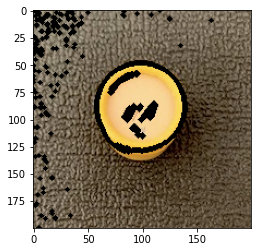

In [14]:
img_gray = cv2.cvtColor(img_q32_rgb, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(img_gray, 170, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_q32_contour = cv2.drawContours(img_q32_rgb, contours, -1, (0,0,0), 3)
plt.imshow(img_q32_contour)

## Filtrage non-linéaire

### Q5.1

Soit cette image :

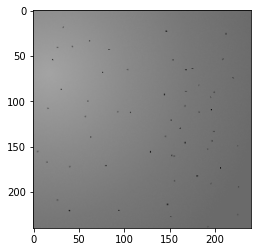

In [15]:
img_q5_org = cv2.imread("images_doc/proc2-q3-sand.png")
img_q5_rgb = cv2.cvtColor(img_q5_org, cv2.COLOR_BGR2RGB)

plt.imshow(img_q5_rgb)

Utilisez un filtre non-linéaire pour retirer les taches noires sur la figure.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fefa5bbe550>,
 <matplotlib.image.AxesImage at 0x7fefa5b492e0>)

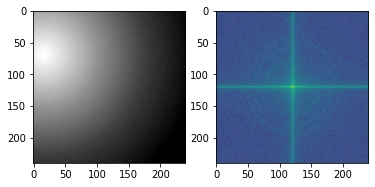

In [20]:
img_q5_mono = cv2.cvtColor(img_q5_org, cv2.COLOR_BGR2GRAY)
img_q5_filt = cv2.medianBlur(img_q5_mono,5)

img_q5_filt_fft = get_fft_mag(img_q5_filt)

plt.subplot(121),plt.imshow(img_q5_filt, cmap='gray')
plt.subplot(122),plt.imshow(img_q5_filt_fft)

## Filtrage morphologique et chaîne de traitement

### Q6.1 

À partir de l'image de la question Q1.2, combinez les filtres vus plus tôt pour ne conserver que le contour de l'objet de la figure (donc sans bruit de fond).

In [21]:
img_q32_clean = img_q32_rgb.copy()